# New Lesson 3: Morphological Operations and Quantifications

You now know how to find objects of interest in an image and produce masks which correspond to these objects. Up until now, we've relied on good image preprocessing to produce quality masks. Now we will talk about morphological operations, which instead focus on making improvements to the masks directly.

1. In this module you will first learn
   What is a morphological operation
   How to choose the right parameters for your morphological operation
   Some common morphological operations
    - Erosion
    - Dilation
    - Opening
    - Closing


2. To quantify the change in nuclear localization and amount of your favorite protein with drug treatment. We would like to be able to answer two questions: 

    1) Does the *total* amount of protein per cell change with drug treatment and 
    2) How does the localization change between the nucleus and the cytoplasm? 
    
    Addressing these questions requires care when choosing the preprocessing algorithms to apply and their ordering, as well as batch processing across datasets.

3. Access properties of cells that have been detected, such as
    - Area
    - Intensity
    - Image vs mask properties
    - Measures of roundness
    - Aspect ratio
    - Convexity
    
   View the statistics of properties of detected cells;
   Filter out unwanted cells based on their properties

### 3.1 Load previously processed data (filter and thresholding)

3.1.1. Load functions

In [94]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage
from scipy.stats import iqr
from ipywidgets import interact
sns.set_style('dark', rc={'image.cmap':'inferno'})

3.1.2. Load images

In [12]:
# MAKE SURE YOU ADD YOUR DIRECTORY BELOW
from skimage.io import imread
data_folder='../Data/Data_ConfocalDrugPanel/'
data_drug = imread(data_folder+"drugA.tif")
data_nodrug = imread(data_folder+"DMSO.tif")

3.1.3. Load meta data

In [13]:
import json
with open(data_folder+'DMSO_metadata.json', mode='r') as f_nodrug:
    meta_nodrug = json.load(f_nodrug)

for key, value in meta_nodrug.items():
    print(key)

drug_slice = {}
nodrug_slice = {}
for idx, channel in enumerate(meta_nodrug['channels']):
    drug_slice[channel] = data_drug[3,:,:,idx]
    nodrug_slice[channel] = data_nodrug[3,:,:,idx] #add in the indexing when read in full dataset
    print(channel)

axes
pixel_size
cell_type
channels
raw_data_date
image_preprocessing_done
your_fav_protein
nucleus
actin


3.1.4. Show images

Text(0.5, 0.98, 'After Drug')

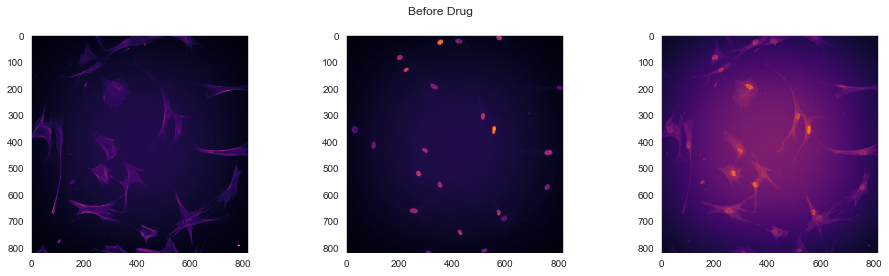

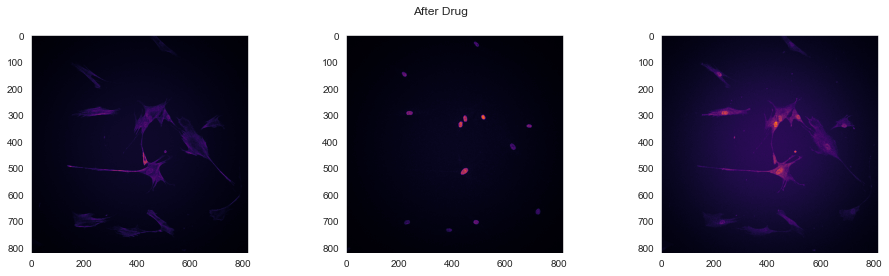

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(nodrug_slice["actin"])
ax[1].imshow(nodrug_slice['nucleus'])
ax[2].imshow(nodrug_slice["your_fav_protein"])
fig.suptitle('Before Drug')

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(drug_slice["actin"])
ax[1].imshow(drug_slice['nucleus'])
ax[2].imshow(drug_slice["your_fav_protein"])
fig.suptitle('After Drug')

3.1.5 Masking


In [15]:
#answer
def mask_im(im, threshold):
    mask = np.zeros(im.shape)
    mask[im >=threshold] = 1
    plt.imshow(mask, vmin = 0, vmax = 1)
    return(mask)

### Morphological Operations

3.2.1 Pre-set

In [135]:
from skimage.filters.rank import median as median_filter # Our Median Filter
from skimage.filters.rank import minimum as min_filter # Our background removal filter
from skimage.filters import threshold_otsu # Our Otsu

import skimage.morphology as sm
from skimage.morphology import disk
from scipy.ndimage import binary_dilation,binary_erosion,binary_opening,binary_closing

3.2.2. Pre-process and threshold and practice making functions



C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:266: UserWarning: Bad rank filter performance is expected due to a large number of bins (65524), equivalent to an approximate bitdepth of 16.0.
  out_dtype)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:266: UserWarning: Bad rank filter performance is expected due to a large number of bins (65375), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


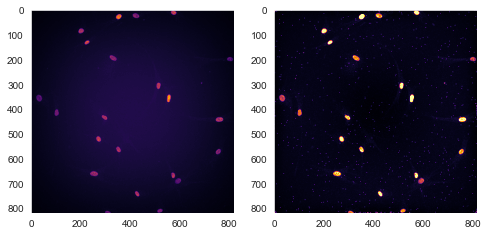

In [136]:
# Let's work only with one channel 
def preprocess_image(image,structuring_radius):
    # Apply the min filt
    filt_image=median_filter(image,disk(1))
    structuring_radius = 50
    structuring_element = disk(structuring_radius)
    background = min_filter(filt_image, structuring_element)
    #substract from image and make sure negative pixels are set to 0
    processed_image=image-background
    processed_image[processed_image<0]=0
    return processed_image
fig,ax=plt.subplots(1,2,figsize=(8,4))
image=nodrug_slice['nucleus']
processed_image=preprocess_image(image,70)
ax[0].imshow(image)
ax[1].imshow(processed_image,vmin=0,vmax=np.min(processed_image)+iqr(processed_image,rng=(0,99.5)))
# Otsu threshold


Binary operations on binary images (thresholded images)

In [137]:
thresholded_image = processed_image<threshold_otsu(processed_image)
thresholded_image.astype(int)
snippet=thresholded_image[600:750,550:700]

@interact
def show_binary_funcs(iteration=range(1,10)):
    fig,ax=plt.subplots(1,3,figsize=(12,4))
    
    ax[0].imshow(snippet,cmap='Greys')
    ax[1].imshow(binary_dilation(snippet,iterations=iteration),cmap='Greys')
    ax[2].imshow(binary_erosion(snippet,iterations=iteration),cmap='Greys')
    ax[1].set_title('Eroding')
    ax[2].set_title('Dilating')
show_binary_funcs

interactive(children=(Dropdown(description='iteration', options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=1), Output(…

<function __main__.show_binary_funcs(iteration=range(1, 10))>

In [139]:
@interact
def show_binary_funcs(iteration=range(1,10)):
    fig,ax=plt.subplots(1,3,figsize=(12,4))
    
    ax[0].imshow(snippet,cmap='Greys')
    ax[1].imshow(binary_closing(snippet,iterations=iteration),cmap='Greys')
    ax[2].imshow(binary_opening(snippet,iterations=iteration),cmap='Greys')
    ax[1].set_title('Closing (first erode, then dilate)')
    ax[2].set_title('Opening (first dilate, then erode)')
show_binary_funcs

interactive(children=(Dropdown(description='iteration', options=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=1), Output(…

<function __main__.show_binary_funcs(iteration=range(1, 10))>

3.2.3. Labeling objects

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:266: UserWarning: Bad rank filter performance is expected due to a large number of bins (65524), equivalent to an approximate bitdepth of 16.0.
  out_dtype)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:266: UserWarning: Bad rank filter performance is expected due to a large number of bins (65375), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


Text(0.5, 1.0, 'Regions labeled')

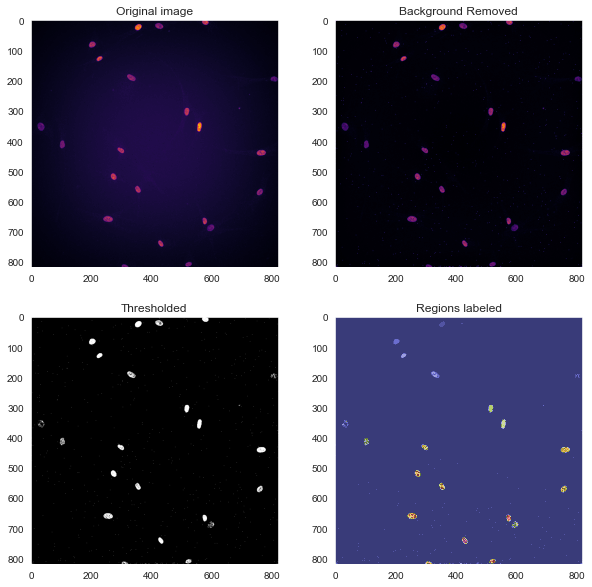

In [256]:
from skimage.measure import label,regionprops
fig,ax=plt.subplots(2,2,figsize=(10,10))

image=nodrug_slice['nucleus']
processed_image=preprocess_image(image,70)

ax[0,0].imshow(image)
ax[0,1].imshow(processed_image)
thresholded_image = processed_image>threshold_otsu(processed_image)
ax[1,0].imshow(thresholded_image,cmap='Greys_r')
labeled_image=label(thresholded_image)
ax[1,1].imshow(labeled_image,cmap='tab20b')

ax[0,0].set_title('Original image')
ax[0,1].set_title('Background Removed')
ax[1,0].set_title('Thresholded')
ax[1,1].set_title('Regions labeled')

In [142]:
num_object=np.max(labeled_image)
num_object #Too many objects are being counted !

721

3.2.4. Optimized Operation Results (Closing-opening)

25

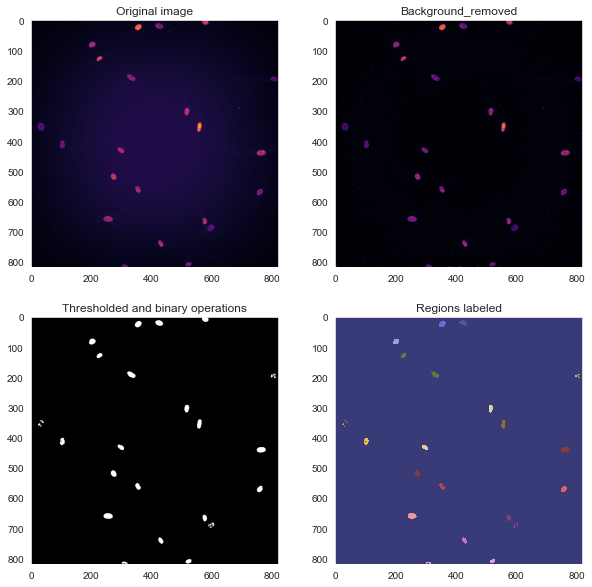

In [143]:
from skimage.morphology import remove_small_holes,remove_small_objects
fig,ax=plt.subplots(2,2,figsize=(10,10))

ax[0,0].imshow(image)
ax[0,1].imshow(processed_image)
thresholded_image = processed_image>threshold_otsu(processed_image)
thresholded_image_operated = remove_small_objects(remove_small_holes(binary_closing(thresholded_image)),min_size=10)
ax[1,0].imshow(thresholded_image_operated,cmap='Greys_r')
labeled_image=label(thresholded_image_operated)
ax[1,1].imshow(labeled_image,cmap='tab20b',interpolation='None')
# for axis in [ax[1,0],ax[1,1]]:
#     axis.set_xlim(200,350)
#     axis.set_ylim(100,230)
ax[0,0].set_title('Original image')
ax[0,1].set_title('Background_removed')
ax[1,0].set_title('Thresholded and binary operations')
ax[1,1].set_title('Regions labeled')
np.max(labeled_image)

(800.0, 0.0)

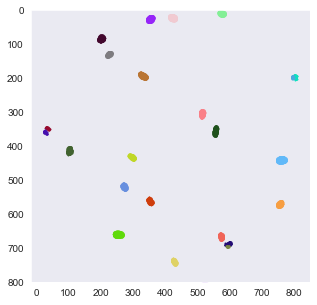

In [160]:
detected_regions=regionprops(labeled_image)
fig,ax=plt.subplots(1,1,figsize=(5,5))
for reg in detected_regions:
    x,y=reg.coords.T
    plt.scatter(y,x,color=np.random.rand(3),s=1)
plt.ylim(800,0)


### 3.3 Quantifications

3.3.1. Find cell body by getting rid of nuclei from the dialated actin mask 

In [193]:
#No drug
cell_body = nodrug_slice['actin']
processed_body=preprocess_image(cell_body,70)
thresholded_body=processed_body>threshold_otsu(processed_body)
adjusted_thresholded_body=remove_small_holes(binary_closing(thresholded_body,iterations=2),area_threshold=500)


C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:266: UserWarning: Bad rank filter performance is expected due to a large number of bins (62602), equivalent to an approximate bitdepth of 15.9.
  out_dtype)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:266: UserWarning: Bad rank filter performance is expected due to a large number of bins (61468), equivalent to an approximate bitdepth of 15.9.
  out_dtype)


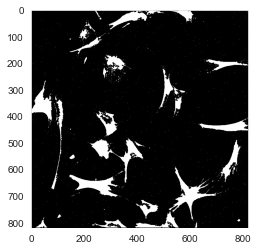

In [194]:
from skimage.morphology import remove_small_holes
plt.imshow(adjusted_thresholded_body,cmap='Greys_r')


In [195]:
#No drug
cell_nucleus = nodrug_slice['nucleus']
processed_nucleus=preprocess_image(cell_nucleus,70)
thresholded_nucleus=processed_nucleus>threshold_otsu(processed_nucleus)
adjusted_thresholded_nucleus=remove_small_holes(binary_closing(thresholded_nucleus,iterations=2),area_threshold=500)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:266: UserWarning: Bad rank filter performance is expected due to a large number of bins (65524), equivalent to an approximate bitdepth of 16.0.
  out_dtype)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:266: UserWarning: Bad rank filter performance is expected due to a large number of bins (65375), equivalent to an approximate bitdepth of 16.0.
  out_dtype)


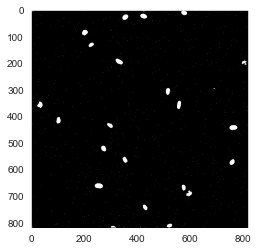

In [196]:
from skimage.morphology import remove_small_holes
plt.imshow(adjusted_thresholded_nucleus,cmap='Greys_r')


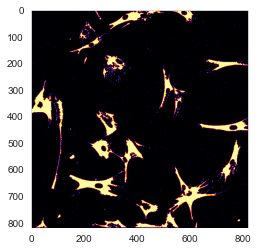

In [202]:
#only cell_body
only_body_thresholded=adjusted_thresholded_body.astype(int)-adjusted_thresholded_nucleus.astype(int)
only_body_thresholded[only_body_thresholded<0]=0 #correct for issues.
plt.imshow(only_body_thresholded)

In [215]:
total_brightness_body_nodrug=np.mean(nodrug_slice['your_fav_protein'][only_body_thresholded>0])
total_brightness_nucleus_nodrug=np.mean(nodrug_slice['your_fav_protein'][adjusted_thresholded_nucleus])
area_body=[r.area for r in regionprops(label(only_body_thresholded))]
area_nucleus=[r.area for r in regionprops(label(adjusted_thresholded_nucleus))]
np.sum(area_body), np.sum(area_nucleus), total_brightness_body_nodrug/np.sum(area_body), total_brightness_nucleus_nodrug/np.sum(area_nucleus)

(50876, 6840, 0.14345959559026678, 1.5993368044868508)

(31645, 2693, 0.22681982665322992, 2.7557029550419463)

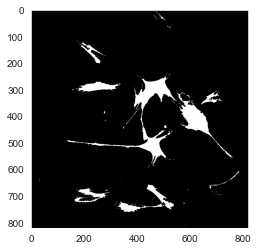

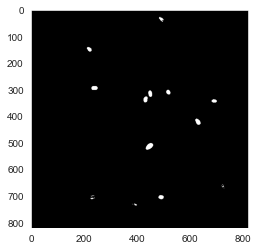

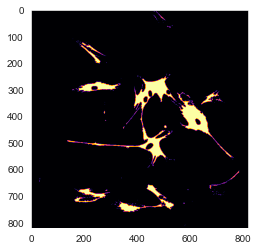

In [239]:
#drug
cell_body = drug_slice['actin']
processed_body=cell_body#preprocess_image(cell_body,70)
thresholded_body=processed_body>threshold_otsu(processed_body)
adjusted_thresholded_body=remove_small_holes(binary_closing(thresholded_body,iterations=2),area_threshold=500)
from skimage.morphology import remove_small_holes
plt.figure()
plt.imshow(adjusted_thresholded_body,cmap='Greys_r')


cell_nucleus = drug_slice['nucleus']
processed_nucleus=cell_nucleus#preprocess_image(cell_nucleus,70)
thresholded_nucleus=processed_nucleus>threshold_otsu(processed_nucleus)
adjusted_thresholded_nucleus=remove_small_holes(binary_closing(thresholded_nucleus,iterations=2),area_threshold=500)
plt.figure()
plt.imshow(adjusted_thresholded_nucleus,cmap='Greys_r')

only_body_thresholded=adjusted_thresholded_body.astype(int)-adjusted_thresholded_nucleus.astype(int)
only_body_thresholded[only_body_thresholded<0]=0 #correct for issues.
plt.figure()
plt.imshow(only_body_thresholded)

total_brightness_body_nodrug=np.mean(nodrug_slice['your_fav_protein'][only_body_thresholded>0])
total_brightness_nucleus_nodrug=np.mean(nodrug_slice['your_fav_protein'][adjusted_thresholded_nucleus])
area_body=[r.area for r in regionprops(label(only_body_thresholded))]
area_nucleus=[r.area for r in regionprops(label(adjusted_thresholded_nucleus))]
np.sum(area_body), np.sum(area_nucleus), total_brightness_body_nodrug/np.sum(area_body), total_brightness_nucleus_nodrug/np.sum(area_nucleus)

In [240]:
## What happens when nuclei are too close together ? Intro to watershedding

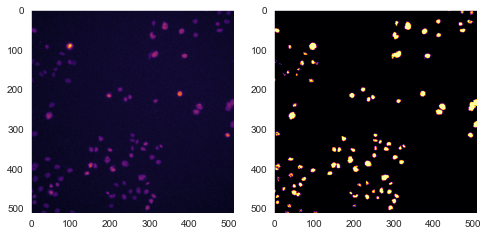

In [249]:
crowded_image = imread('../Data/L4Data/ImagesAll/HAC-Cit-KRAB+dox_w2YFPled_s41_t271.TIF')
fig,ax=plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(crowded_image)
ax[1].imshow(crowded_image>threshold_otsu(crowded_image))

Text(0.5, 1.0, 'Overlapped cells detected as single cells !')

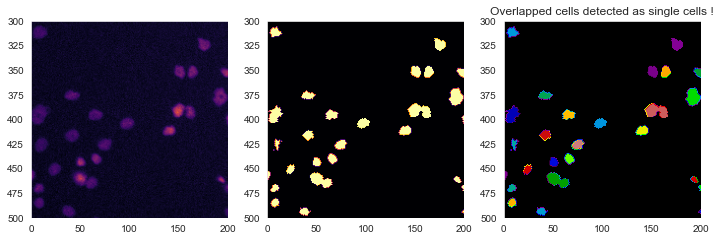

In [264]:
fig,ax=plt.subplots(1,3,figsize=(12,4))

ax[0].imshow(crowded_image)
thresholded=remove_small_holes(binary_closing(crowded_image>threshold_otsu(crowded_image)))
ax[1].imshow(thresholded)
labeled=label(thresholded)
reorder=np.arange(int(np.max(labeled))+1)
np.random.shuffle(reorder)
reorder[0]=0
labeled=reorder[labeled]
ax[2].imshow(labeled,cmap='nipy_spectral')
for a in ax:
    a.set_xlim(0,200)
    a.set_ylim(500,300)
ax[2].set_title('Overlapping cells detected as single cells !')

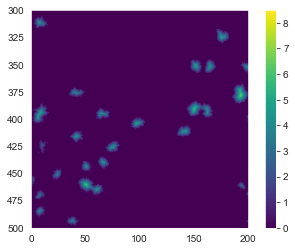

In [287]:
from scipy.ndimage import distance_transform_edt
distance_transformed=distance_transform_edt(thresholded)
plt.imshow(distance_transformed,cmap='viridis')
plt.xlim(0,200)
plt.ylim(500,300)
plt.colorbar()

In [288]:
regions=regionprops(label(thresholded))
regions=[r for r in regions if r.area>10]
radii = [r.equivalent_diameter/2 for r in regions]
median_radius = np.median(radii)

In [292]:
from skimage.feature import peak_local_max


(500.0, 300.0)

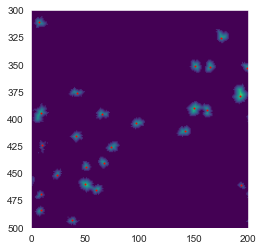

In [300]:
y_max,x_max=peak_local_max(distance_transformed,min_distance=int(median_radius)).T
plt.imshow(distance_transformed,cmap='viridis')
plt.scatter(x_max,y_max,color='r',s=1)
plt.xlim(0,200)
plt.ylim(500,300)

(500.0, 300.0)

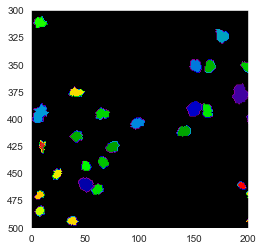

In [314]:
from skimage.segmentation import watershed
markers=np.zeros(distance_transformed.shape)
markers[y_max,x_max]=np.arange(1,len(y_max)+1)
watershedded_label=watershed(-distance_transformed,mask=thresholded,markers=markers,watershed_line=True)
plt.imshow(watershedded_label,cmap='nipy_spectral')
plt.xlim(0,200)
plt.ylim(500,300)